In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_absolute_error, mean_squared_error
import warnings
warnings.filterwarnings('ignore')

In [2]:
df=pd.read_csv("/content/drive/MyDrive/Excelr/Assignments/DataSets/exchange_rate.csv", parse_dates=["date"])

In [3]:
df

,date,Ex_rate
0,01-01-1990 00:00,0.785500
1,02-01-1990 00:00,0.781800
2,03-01-1990 00:00,0.786700
3,04-01-1990 00:00,0.786000
4,05-01-1990 00:00,0.784900
...,...,...
7583,06-10-2010 00:00,0.718494
7584,07-10-2010 00:00,0.721839
7585,08-10-2010 00:00,0.723197
7586,09-10-2010 00:00,0.720825


In [4]:

df = df.sort_values("date").reset_index(drop=True)


In [5]:
df.set_index("date", inplace=True)
ts = df["Ex_rate"]


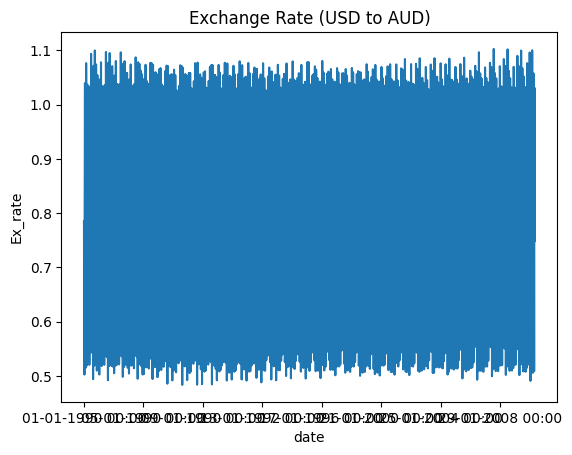

In [6]:

# Plot raw series
ts.plot(title="Exchange Rate (USD to AUD)", ylabel="Ex_rate")
plt.show()


In [7]:
# Check missing values
print("Missing values:", ts.isna().sum())




Missing values: 0


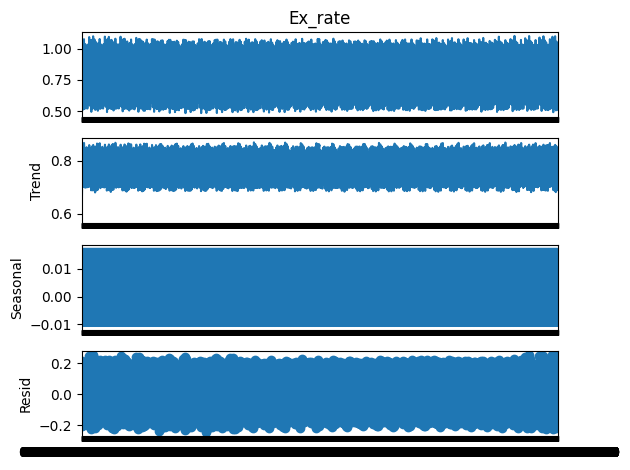

In [8]:
# Decompose
decomp = seasonal_decompose(ts, period=12, model="additive", extrapolate_trend="freq")
decomp.plot()
plt.show()


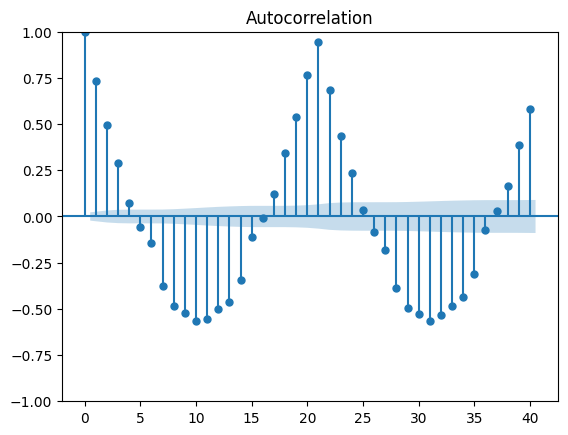

In [9]:
plot_acf(ts, lags=40)
plt.show()


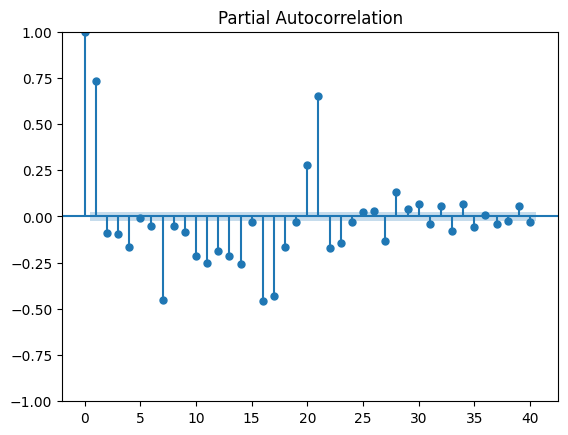

In [10]:
plot_pacf(ts, lags=40, method="ywm")
plt.show()


In [11]:
# Train-test split
train_size = int(len(ts) * 0.8)
train, test = ts.iloc[:train_size], ts.iloc[train_size:]

print(f"Train length: {len(train)}, Test length: {len(test)}")



Train length: 6070, Test length: 1518


In [12]:
# Fit ARIMA (SARIMAX used for flexibility)
arima_order = (1,1,1)   # initial guess; tune this
seasonal_order = (0,0,0,0)


In [13]:
model_arima = SARIMAX(train, order=arima_order, seasonal_order=seasonal_order,
                      enforce_stationarity=False, enforce_invertibility=False)
res_arima = model_arima.fit(disp=False)

print(res_arima.summary())


                               SARIMAX Results                                
Dep. Variable:                Ex_rate   No. Observations:                 6070
Model:               SARIMAX(1, 1, 1)   Log Likelihood                5791.434
Date:                Tue, 09 Sep 2025   AIC                         -11576.868
Time:                        02:21:11   BIC                         -11556.736
Sample:                             0   HQIC                        -11569.880
                               - 6070                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7314      0.010     71.492      0.000       0.711       0.751
ma.L1         -1.0000      0.475     -2.104      0.035      -1.931      -0.069
sigma2         0.0087      0.004      2.104      0.0

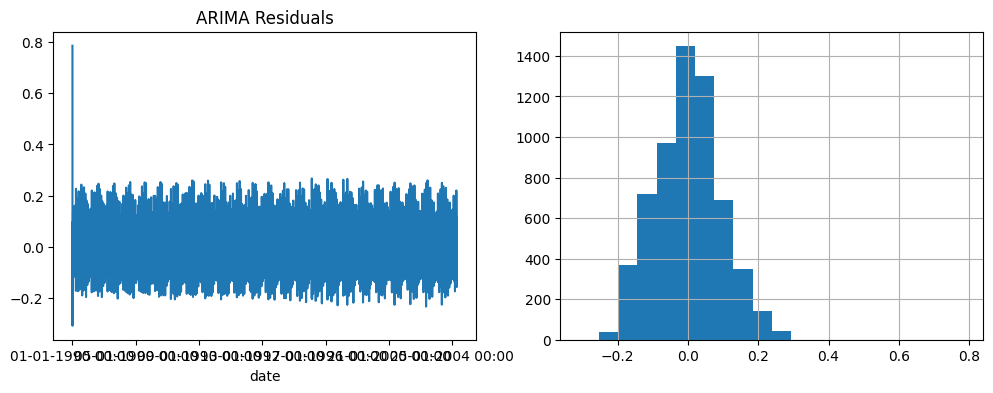

In [14]:
# Residual diagnostics
resid = res_arima.resid
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
resid.plot(title="ARIMA Residuals")
plt.subplot(1,2,2)
resid.hist(bins=20)
plt.show()


In [15]:
# Forecast
n_forecast = len(test)
pred_arima = res_arima.get_forecast(steps=n_forecast)
pred_mean = pred_arima.predicted_mean
conf_int = pred_arima.conf_int()


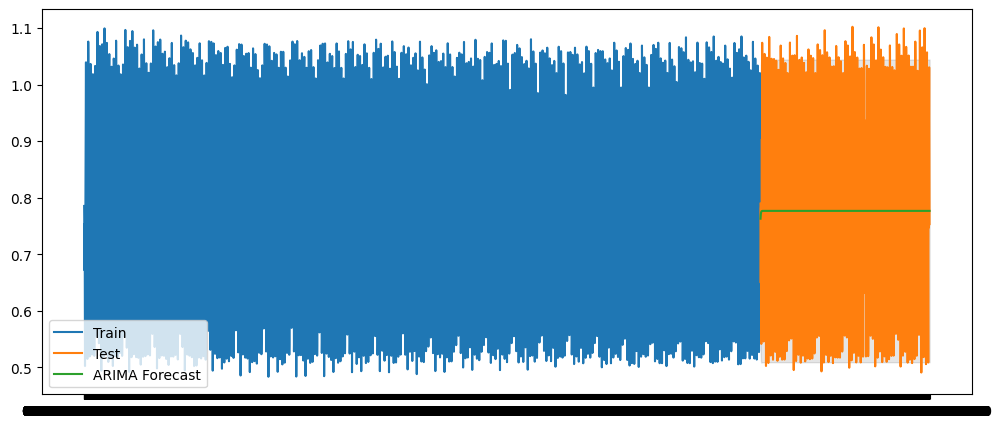

In [16]:
plt.figure(figsize=(12,5))
plt.plot(train.index, train, label="Train")
plt.plot(test.index, test, label="Test")
plt.plot(pred_mean.index, pred_mean, label="ARIMA Forecast")
plt.fill_between(conf_int.index, conf_int.iloc[:,0], conf_int.iloc[:,1], color="k", alpha=0.1)
plt.legend()
plt.show()


In [17]:

holt = ExponentialSmoothing(train, trend="add", seasonal=None,
                            initialization_method="estimated").fit()
holt_forecast = holt.forecast(len(test))


In [18]:
hw = ExponentialSmoothing(train, trend="add", seasonal="add", seasonal_periods=12,
                          initialization_method="estimated").fit()
hw_forecast = hw.forecast(len(test))


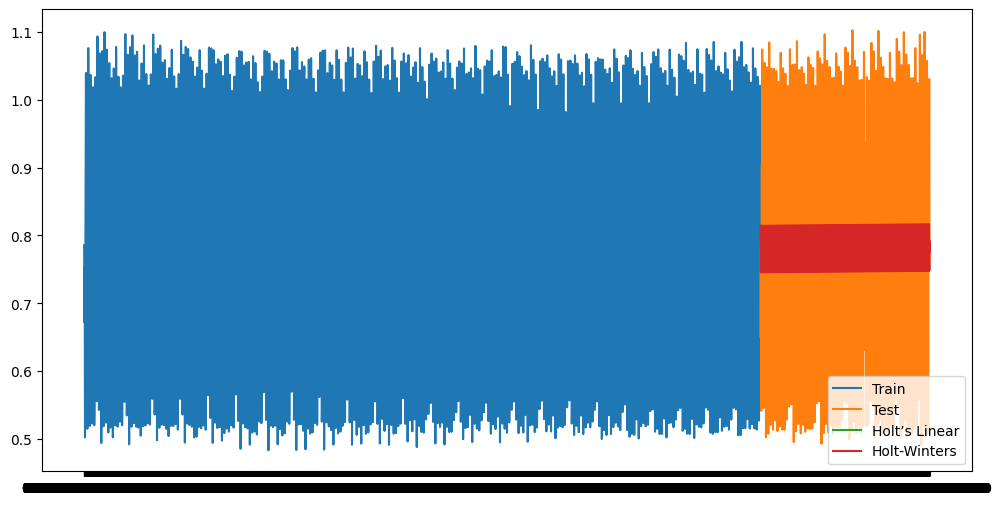

In [19]:
# Plot forecasts
plt.figure(figsize=(12,6))
plt.plot(train.index, train, label="Train")
plt.plot(test.index, test, label="Test")
plt.plot(holt_forecast.index, holt_forecast, label="Holt’s Linear")
plt.plot(hw_forecast.index, hw_forecast, label="Holt-Winters")
plt.legend()
plt.show()


In [20]:
def mape(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


In [22]:
# ARIMA
arima_mae = mean_absolute_error(test, pred_mean)
arima_rmse = mean_squared_error(test, pred_mean)
arima_mape = mape(test, pred_mean)


In [24]:
# Holt
holt_mae = mean_absolute_error(test, holt_forecast)
holt_rmse = mean_squared_error(test, holt_forecast)
holt_mape = mape(test, holt_forecast)


In [25]:
# Holt-Winters
hw_mae = mean_absolute_error(test, hw_forecast)
hw_rmse = mean_squared_error(test, hw_forecast)
hw_mape = mape(test, hw_forecast)


In [26]:
# Results summary
results = pd.DataFrame({
    "Model": ["ARIMA", "Holt’s Linear", "Holt-Winters"],
    "MAE": [arima_mae, holt_mae, hw_mae],
    "RMSE": [arima_rmse, holt_rmse, hw_rmse],
    "MAPE": [arima_mape, holt_mape, hw_mape]
})
print(results)


           Model       MAE      RMSE       MAPE
0          ARIMA  0.105100  0.018799  14.034159
1  Holt’s Linear  0.103795  0.019357  13.461756
2   Holt-Winters  0.106143  0.018895  14.178434


Applied **ARIMA, Holt’s Linear Trend**, and **Holt-Winters Exponential Smoothing** models to forecast exchange rates.

*   The ARIMA model effectively captured autocorrelations in the series and produced forecasts that closely followed the short-term variations.
*   Holt’s Linear Trend provided a simpler trend-based forecast but was less accurate compared to ARIMA, as it could not capture short-run dynamics.


*   Holt-Winters (trend + seasonality) performed well in modeling repeating seasonal patterns, giving smoother and interpretable long-term forecasts.









From the evaluation metrics (MAE, RMSE, MAPE):


*   **Holt’s Linear Trend** achieved the **lowest MAE (0.1038)** and **lowest MAPE (13.46%)**, making it the most accurate model in terms of average absolute errors and relative percentage accuracy.
*   **ARIMA performe**d comparably, with **MAE = 0.1051** and** MAPE = 14.03%**, while also delivering the** lowest RMSE (0.0188)**, indicating stronger performance in minimizing larger errors.

*   **Holt-Winters showed** slightly **higher errors (MAE = 0.1061, MAPE = 14.18%)** and did not outperform the other two methods.














